# GSF Training Model

In [46]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem

random.seed(42)

In [47]:

import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
    hamming_loss,
    jaccard_score,
)
import matplotlib.pyplot as plt


# Data Processing

In [48]:
chembl_df = pd.read_csv("../../data/ExperimentData/pChEMBL_data.csv")
print(chembl_df.head())

  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active  


## Process the data

### Remove duplicates

In [49]:
# check if there are duplicated values in the dataframes
print(chembl_df["Molecule ChEMBL ID"].duplicated().sum())

# remove duplicates
chembl_df_unique = chembl_df.drop_duplicates(subset="Molecule ChEMBL ID")
print(chembl_df_unique.shape)
print(chembl_df_unique.head())


421
(860, 4)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active  


### split to psy and non-psy

In [50]:
# Filter out rows where "Comment" is "Not Determined"
filtered_df = chembl_df_unique[chembl_df_unique["Comment"] != "Not Determined"].copy()

# Fill NaN values with 0
filtered_df.fillna(0, inplace=True)

# Print the shape of the filtered DataFrame
print(filtered_df.shape)

# Drop the "Comment" column
combine_psy_nonpsy = filtered_df.drop(["Comment"], axis=1)

# Print the first few rows of the resulting DataFrame
print(combine_psy_nonpsy.head())


(840, 4)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value  
0           8.52  
1           7.40  
2           6.23  
3           0.00  
4           0.00  


## Extract group tokan by autofragmentation

In [51]:
# data preparation for fragmenting using X_train
SMILES_autofragmentation = combine_psy_nonpsy["Smiles"].tolist()

print(SMILES_autofragmentation)

['Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1', 'COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1', 'c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1', 'Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CC1', 'Clc1cccc(N2CCNCC2)c1', 'COc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc2c(ccc3cnn(C[C@H](C)N)c32)o1', '[2H]C([2H])([2H])N1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'CN1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'Cl.Oc1ccc(O)c(C2NCCc3c2[nH]c2ccc(F)cc32)c1', 'Clc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1', 'Cl.Oc1ccc(C2NCCc3c2[nH]c2ccc(Cl)cc32)cc1', 'Cl.Fc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1F', 'Cl.Oc1ccccc1C1NCCc2c1[nH]c1ccc(Cl)cc21', 'Cc1noc(C)c1C1NCCc2c1[nH]c1ccc(F)cc21.Cl', 'Cc1cc(C2NCCc3c2[nH]c2ccc(Cl)cc32)sc1Br.Cl', 'CC1CNCCc2cc(F)c(Cl)cc21', 'Oc1cccc2[nH]cc(CCN3CCC3)c12', 'CC1CNCCc2cc(O)c(Br)cc21', 'CC1CNCCc2c(Cl)cccc21', 'Clc1ccccc1O[C@H]1CCCc2ccc(N3CCNCC3)nc21', 'C[C@@H]1CNC[C@H]2Cc3ccc(COCC4CC4)nc3N21', 'CC1CNCCc2ccc(C(F)(F)F)cc21', 'CC

### mmpa

In [52]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in SMILES_autofragmentation]

# extracting a set of reasonable groups using fragmentation
fragments_mmpa = gsf.fragment_mols(molecules, method="fraggle")

# create a dictionary of fragments for tracking
vocab_fragment_mmpa = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments_mmpa)
    ]
)

print(fragments_mmpa)
print(len(fragments_mmpa))


  0%|          | 0/840 [00:00<?, ?it/s]

[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
  0%|          | 1/840 [00:00<02:18,  6.05it/s][20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
  0%|          | 2/840 [00:00<02:04,  6.71it/s][20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] non-ring atom 3 marked aromatic
[20:59:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
  1%|▏         | 11/840 [00:01<01:12, 11.51it/s][20:59:10] non-ring atom 18 marked aromatic
[20:59:10] non-ring atom 16 marked aromatic
[20:59:10] non-ring atom 6 m

['C1C(*1)C1(C*1)*1', 'FC(F)(F)*1', 'COC1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'CC1=C(C(=O)*1)SC(C2=CC=CC3=CC=CC=C32)=N1', 'C1CC(*1)=C(*1)CN1', 'FC(F)(F)C1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1(*1)C(*1)N(*1)[C@H](*1)C(*1)N1*1', 'C1CC(*1)=C(*1)C(*1)CN1', 'C=CCO*1', 'C1=CC(*1)=C2C(=C1)NC=C2*1', 'O=C1C(*1)=C(*1)[C@@H]2CNCCN12', 'O=C(N1CCOCC1)*1', 'FCCO*1', 'C1CN(*1)CCO1', 'NCCC1=CNC(*1)=C1*1', 'C1=C(C2=NNC(*1)=C2*1)CNCC1', 'C1CN2C(*1)=C(*1)CCC2CN1', 'C1(*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1[C@@H](*1)C(*1)C(*1)N1*1', 'O=C(N1CCC(CO)CC1)*1', 'NC[C@H]1C[C@@H]1C1=CC(*1)=CC=C1*1', 'O=C1C(*1)=C(*1)C[C@@H]2CNCCN12', 'C1=CC2=CC(*1)=CC=C2C(*1)=C1', 'N1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'COC1=CC=C(F)C=C1[C@H]1C[C@@H]1*1', 'CN(C*1)C*1', 'CCC1=CC2=C([C@H]3C[C@@H]3CN)C(*1)=CC=C2O1', 'CC(C*1)N*1', 'C1=C(OC*1)C([C@H]2C[C@@H]2CN(*1)*1)=CC(*1)=C1', 'C1=CC2=C(C(*1)=C1)N(*1)CCNC2', 'CC1=C(*1)SC(C2=CC=CC3=CC=CC=C32)=N1', 'C[C@H](N)CN1CCC(*1)=C1*1', 'NC[C@H]1C[C@@H]1C1=C2CCOC2=CC=C1*1', 'OCC1CCN(*1)CC1', 'O=C1C2=C(C(F)(F)F)C=CC=C

In [53]:
grammar_auto_mmpa = gsf.GroupGrammar(vocab=vocab_fragment_mmpa)

### mmpa fragmentation on chembl data

In [54]:
encode_input = [Chem.MolFromSmiles(smiles) for smiles in combine_psy_nonpsy["Smiles"]]

In [55]:
group_selfie_mmpa = []
extracted_groups_mmpa = []


for smiles in encode_input:
    encode_mol = grammar_auto_mmpa.full_encoder(smiles)
    group_selfie_mmpa.append(encode_mol)
    extracted = grammar_auto_mmpa.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_mmpa.append(extracted_group)
    print(extracted_group)

print(extracted_groups_mmpa)


['frag35', 'frag17']
['frag35', 'frag2']


['frag37']
['frag17']
['frag28']
['frag17', 'frag0']
['frag17']
['frag2', 'frag6']
['frag6', 'frag17']
['frag17']
['frag9']
['frag9']
['frag41', 'frag17']
['frag36', 'frag17']
['frag36', 'frag17']
['frag41', 'frag17']
['frag36', 'frag17']
['frag41']
['frag36']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17', 'frag23']
['frag23', 'frag0']
['frag5']
['frag17']
['frag2']
['frag17', 'frag0']
['frag6', 'frag17']
['frag2', 'frag6']
['frag6', 'frag17']
['frag6', 'frag17']
['frag6', 'frag17']
['frag2', 'frag17']
['frag2', 'frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag9', 'frag25']
['frag17']
['frag11', 'frag23']
['frag22', 'frag11']
['frag3', 'frag23']
['frag17']
['frag17', 'frag17']
['frag17']
['frag17']
['frag2', 'frag0']
['frag17']
['frag17']
['frag5']
['frag17']
['frag5']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17']
['frag17', 'frag17']
['frag34']
['frag5', 'frag6']
['frag5', 'frag6']
['frag2', 'frag0']
['

### one-hot encoding

In [56]:
# Convert to DataFrame with a single column of fragment groups
df = pd.DataFrame({"Fragments": extracted_groups_mmpa})

# Explode the lists to get one fragment per row
df_exploded = df.explode("Fragments")

# Perform one-hot encoding but limit the columns to the predefined fragment names
# Create a list of predefined fragment names
predefined_fragments = [f"frag_frag{i}" for i in range(len(fragments_mmpa))]

# Perform one-hot encoding only for the predefined fragment names
one_hot = pd.get_dummies(df_exploded["Fragments"], prefix="frag")

# Make sure the one-hot encoding has exactly the predefined columns (frag0 to frag83)
one_hot = one_hot.reindex(columns=predefined_fragments, fill_value=0)

# Group by the original index to aggregate back to list-level encoding
one_hot_encoded = one_hot.groupby(level=0).max().astype(int)

# Print the final result
print(one_hot_encoded)
# one_hot_encoded.to_csv("psy_nonpsy_onehot1.csv")


     frag_frag0  frag_frag1  frag_frag2  frag_frag3  frag_frag4  frag_frag5  \
0             0           0           0           0           0           0   
1             0           0           1           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
835           0           0           0           0           0           0   
836           0           0           0           0           0           0   
837           0           0           0           0           0           0   
838           0           0           0           0           0           0   
839           0           0           0           0           0           0   

     frag_frag6  frag_frag7  frag_frag8  frag_frag9

# Training

In [57]:
X = one_hot_encoded
y_label = (combine_psy_nonpsy["pChEMBL Value"] > 0).astype(int)
y_value = combine_psy_nonpsy["pChEMBL Value"]


print(X.shape, y_label.shape, y_value.shape)
print(X.head())
print(y_label.head())


(840, 43) (840,) (840,)
   frag_frag0  frag_frag1  frag_frag2  frag_frag3  frag_frag4  frag_frag5  \
0           0           0           0           0           0           0   
1           0           0           1           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   frag_frag6  frag_frag7  frag_frag8  frag_frag9  ...  frag_frag33  \
0           0           0           0           0  ...            0   
1           0           0           0           0  ...            0   
2           0           0           0           0  ...            0   
3           0           0           0           0  ...            0   
4           0           0           0           0  ...            0   

   frag_frag34  frag_frag35  frag_frag36  frag_frag37  frag_frag38  \
0            0  

### Single Label

In [58]:
# Nested cross-validation setup
outer_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(accuracy_score, greater_is_better=True)
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean()


[I 2025-01-15 21:00:37,687] A new study created in memory with name: no-name-e92b1eb7-dc5d-4e54-abd5-c12fb8f43aca
[I 2025-01-15 21:00:38,146] Trial 0 finished with value: 0.7290768380320618 and parameters: {'n_estimators': 65, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.7290768380320618.
[I 2025-01-15 21:00:38,198] Trial 1 finished with value: 0.7231398562741845 and parameters: {'n_estimators': 13, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.7290768380320618.
[I 2025-01-15 21:00:38,329] Trial 2 finished with value: 0.7186733001658375 and parameters: {'n_estimators': 38, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: 0.7290768380320618.
[I 2025-01-15 21:00:38,380] Trial 3 finished with value: 0.723150912106136 and parameters: {'n_estimators': 11, 'max_depth': 6, 'min_samples_split': 5

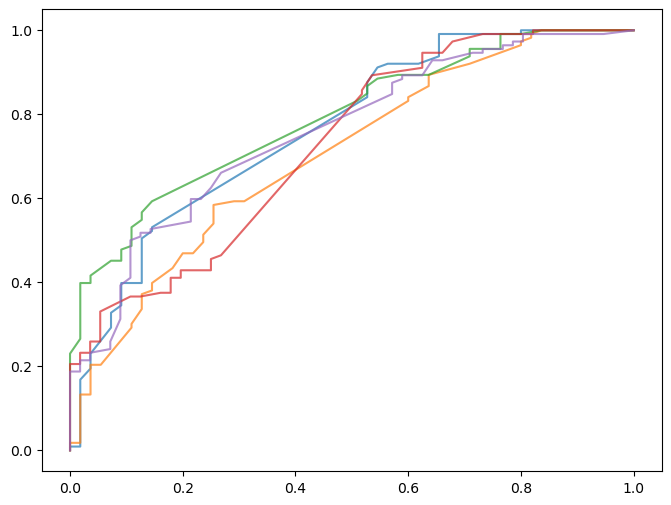

In [59]:
# Outer loop: Statistical evaluation
outer_scores = []
# ncv_label_scores = {label: [] for label in y.columns}

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y_label), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    # Skip fold if only one class is present
    if len(np.unique(y_test)) < 2:
        print(
            f"Fold {fold}: Only one class present in y_test. Skipping ROC computation."
        )
        continue

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})", alpha=0.7)

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
        }
    )


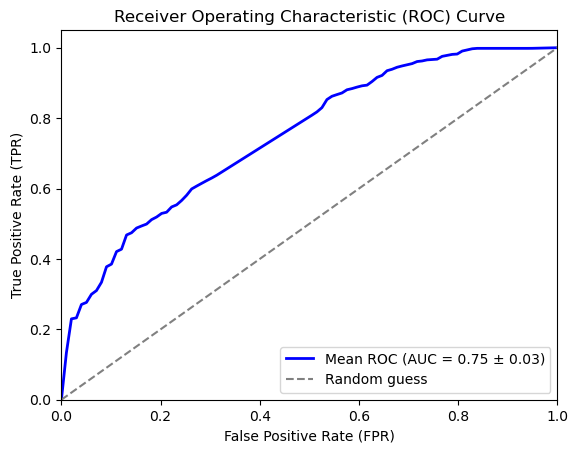

Accuracy: Mean = 0.74, Std = 0.01
F1_score: Mean = 0.69, Std = 0.02
Fold 1:
  accuracy: 0.7440
  f1_score: 0.7128
Fold 2:
  accuracy: 0.7143
  f1_score: 0.6541
Fold 3:
  accuracy: 0.7440
  f1_score: 0.6877
Fold 4:
  accuracy: 0.7500
  f1_score: 0.6995
Fold 5:
  accuracy: 0.7262
  f1_score: 0.6846


In [60]:
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


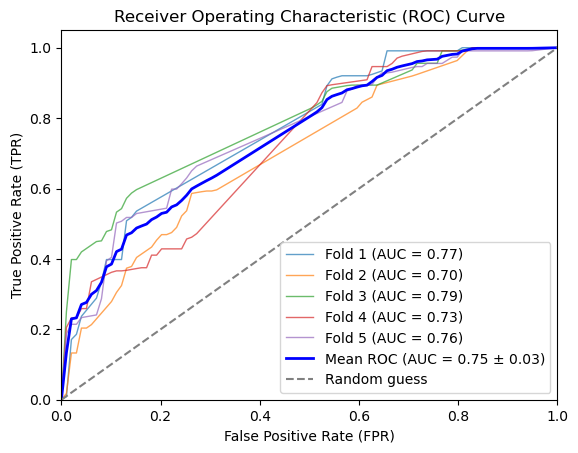

Accuracy: Mean = 0.74, Std = 0.01
F1_score: Mean = 0.69, Std = 0.02
Fold 1:
  accuracy: 0.7440
  f1_score: 0.7128
Fold 2:
  accuracy: 0.7143
  f1_score: 0.6541
Fold 3:
  accuracy: 0.7440
  f1_score: 0.6877
Fold 4:
  accuracy: 0.7500
  f1_score: 0.6995
Fold 5:
  accuracy: 0.7262
  f1_score: 0.6846


In [61]:
# Compute and plot ROC curve for each fold
# plt.figure(figsize=(10, 8))

for fold, tpr in enumerate(tprs, start=1):
    # Plot each fold's ROC curve
    plt.plot(
        mean_fpr,
        tpr,
        lw=1,
        alpha=0.7,
        label=f"Fold {fold} (AUC = {aucs[fold-1]:.2f})",
    )

# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


In [62]:
print(best_params)

{'n_estimators': 38, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
